In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 25, 25

In [2]:
patient = pd.read_csv('./data/PatientInfo.csv', index_col="patient_id")

# drop columns that I don't need for network graph
patient = patient[["infection_case","infected_by"]]

# infected_by has some dirty data in it, fixing them
patient.index = patient.index.astype(str)

# Was able to find the proper fix for patient_id 1000000003
# https://www.straitstimes.com/asia/east-asia/wuhan-virus-south-korea-reports-first-local-human-to-human-transmission
patient.loc["1000000003"].infected_by = "2000000001"

# 1000000062 case was difficult to find any info on, and variants of 2017000005 didn't result in any patient 
# ids with reasonable dates.  I decided to convert this into a NaN
patient.loc["1000000062"].infected_by = np.nan

# 5000000022 was simple to fix, this is the only case where there are 2 infected_by, and both 1500000050 and
# 1500000055 have the same province and infection_case, which means that the graph wouldn't be affected if we
# picked one
patient.loc["5000000022"].infected_by = "1500000050"

# 5100000022 and 5100000023, no idea how to fix these.  There are 2 options: 1. Attribute it to 5100000021 as
# it's the only other local case in a reasonable time frame, or, 2. Remove the attribution.  I will do 2 here.
patient.loc["5100000022"].infected_by = np.nan
patient.loc["5100000023"].infected_by = np.nan
patient.loc["5100000022"].infection_case = "etc"
patient.loc["5100000023"].infection_case = "etc"

# The last 3 patients in Gyeongsangnam-do were amongst a huge list of people that were tested in affiliation
# with the Shincheonji Church or in contact with them.  Seeing that members of the church were likely to be
# tagged with infection_case = Shincheonji Church, I opted to assign them to be infected by a confirmed case
# from the Shincheonji Church, rather than assigning them to the group.  Note: There was also a few affilited
# with Geochang Church but these were the people confirmed or showed symtoms in Geochang-gun, so I ruled that
# out.  Might be wrong but Shincheonji Church were responsible for majority of the spread during this period
# that adding 3 cases to their name will not be significant anyways, sorry patient # 6100000028!

patient.loc["6100000034"].infected_by = "6100000028"
patient.loc["6100000035"].infected_by = "6100000028"
patient.loc["6100000036"].infected_by = "6100000028"

patient = patient.reset_index()

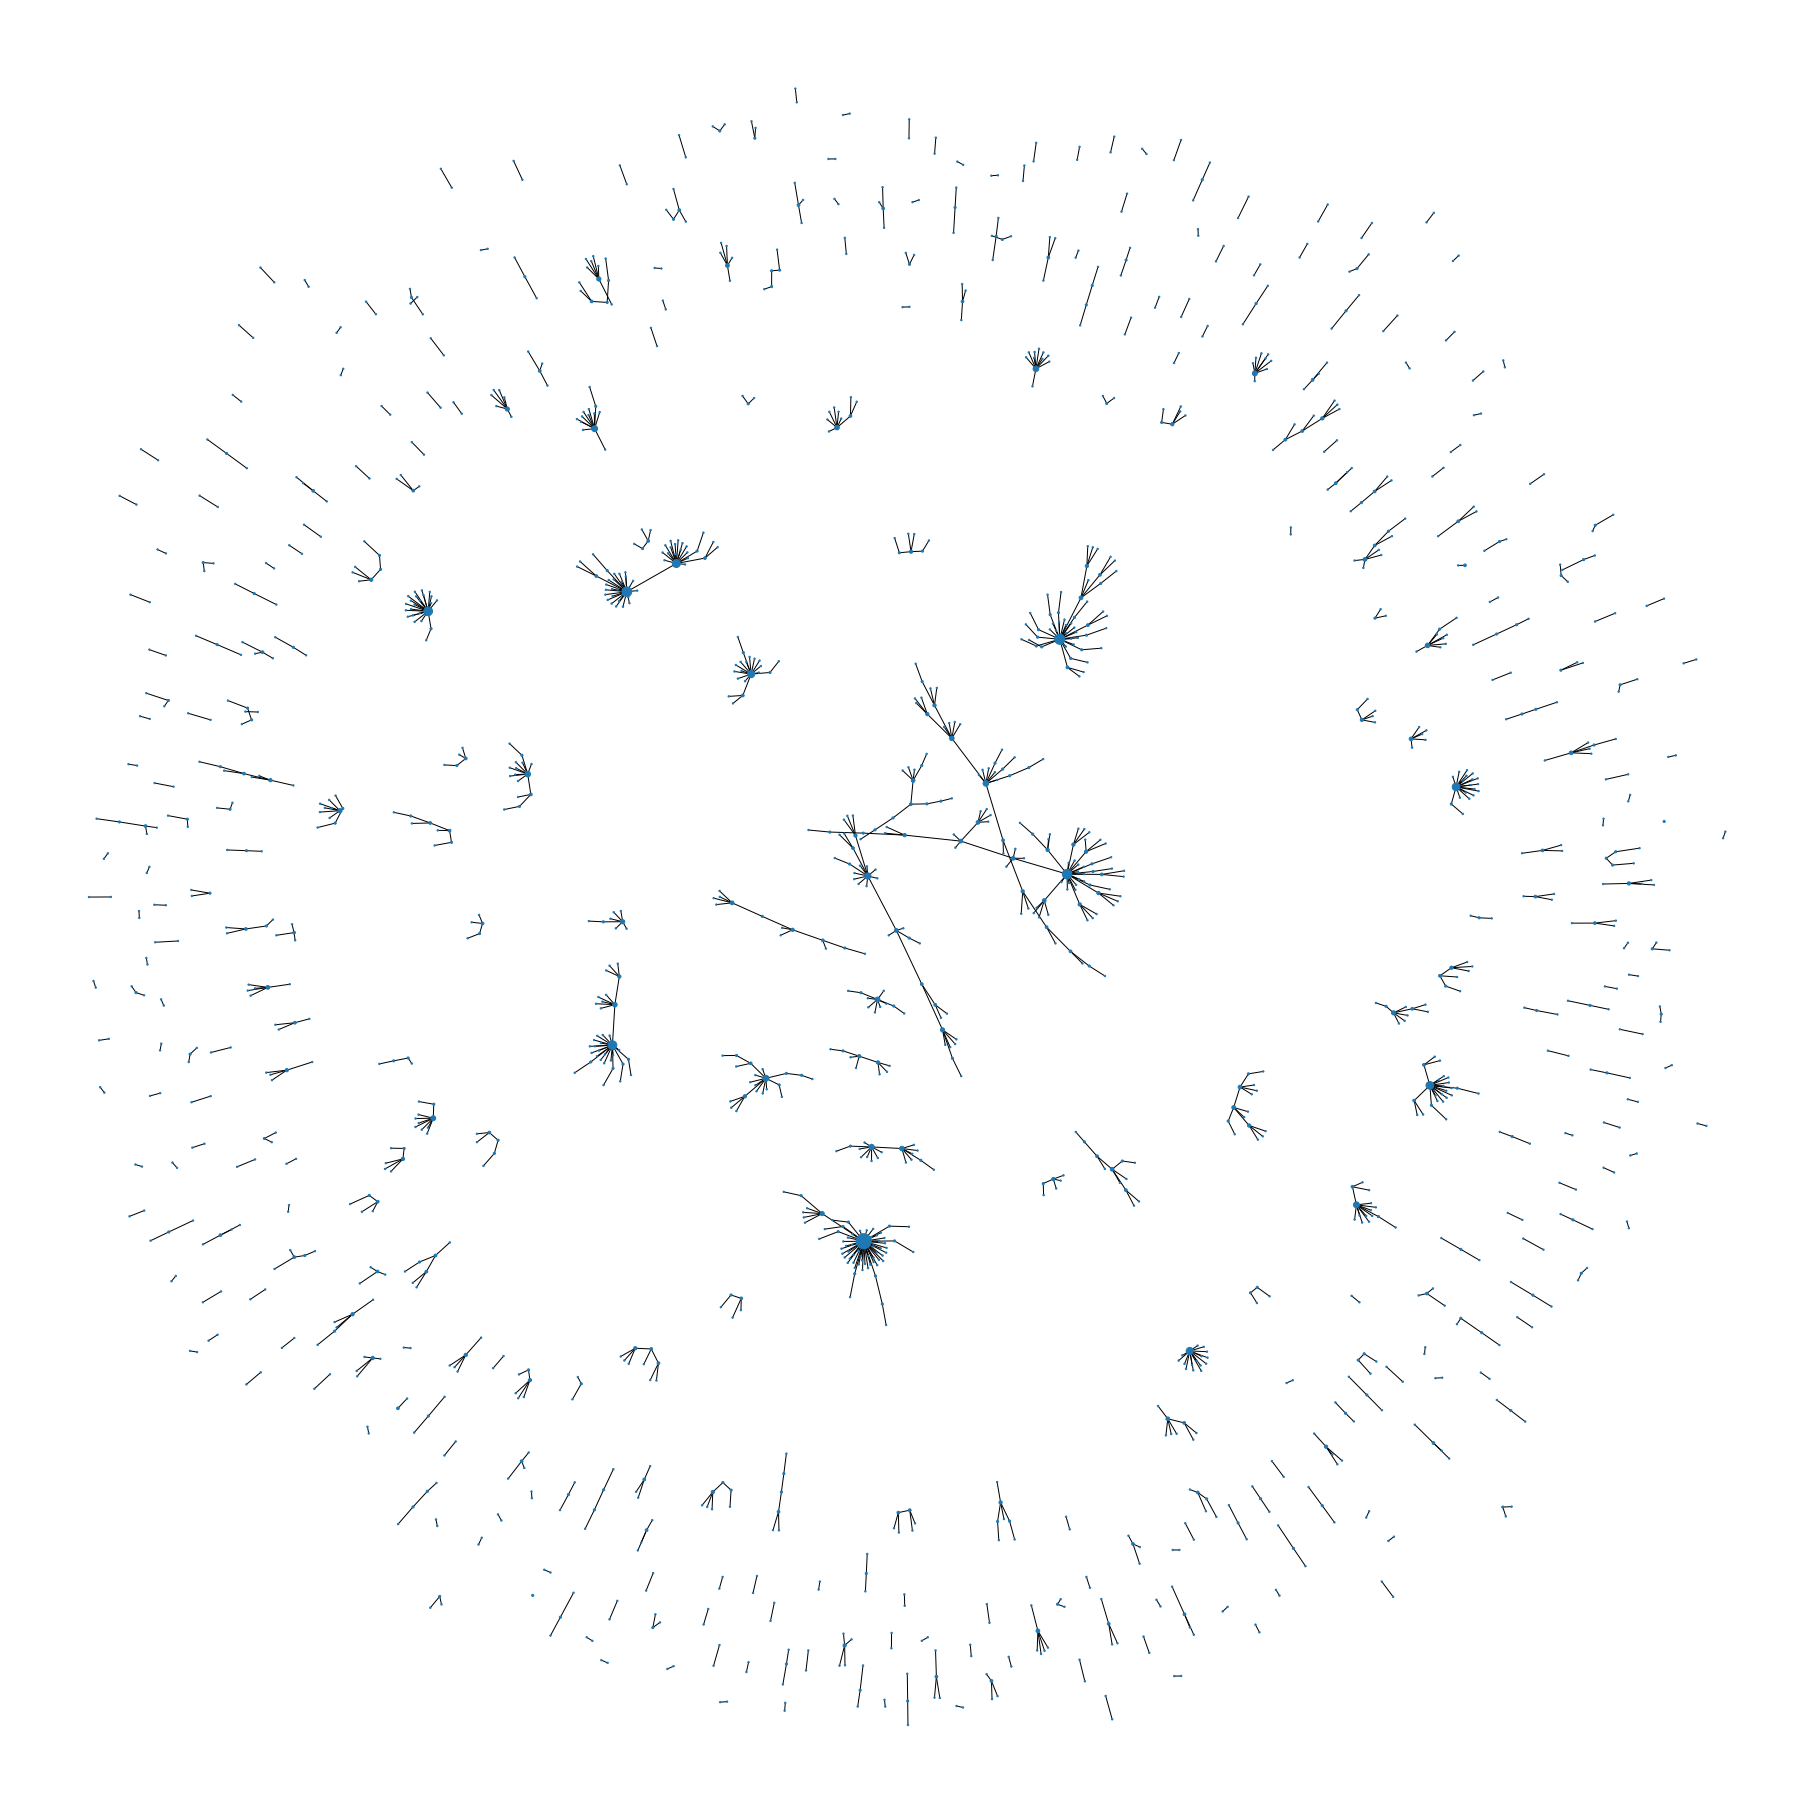

In [3]:
G = nx.Graph()

for _, row in patient.iterrows():
    if (not pd.isnull(row['infected_by'])):
        G.add_edge(row.patient_id,row.infected_by)

d = dict(G.degree)

nx.draw_spring(G, with_labels=False, nodelist=d.keys(), node_size=[v**1.2 * 2 for v in d.values()])

plt.show()

# this ONLY shows direct infected by indicated in patient data

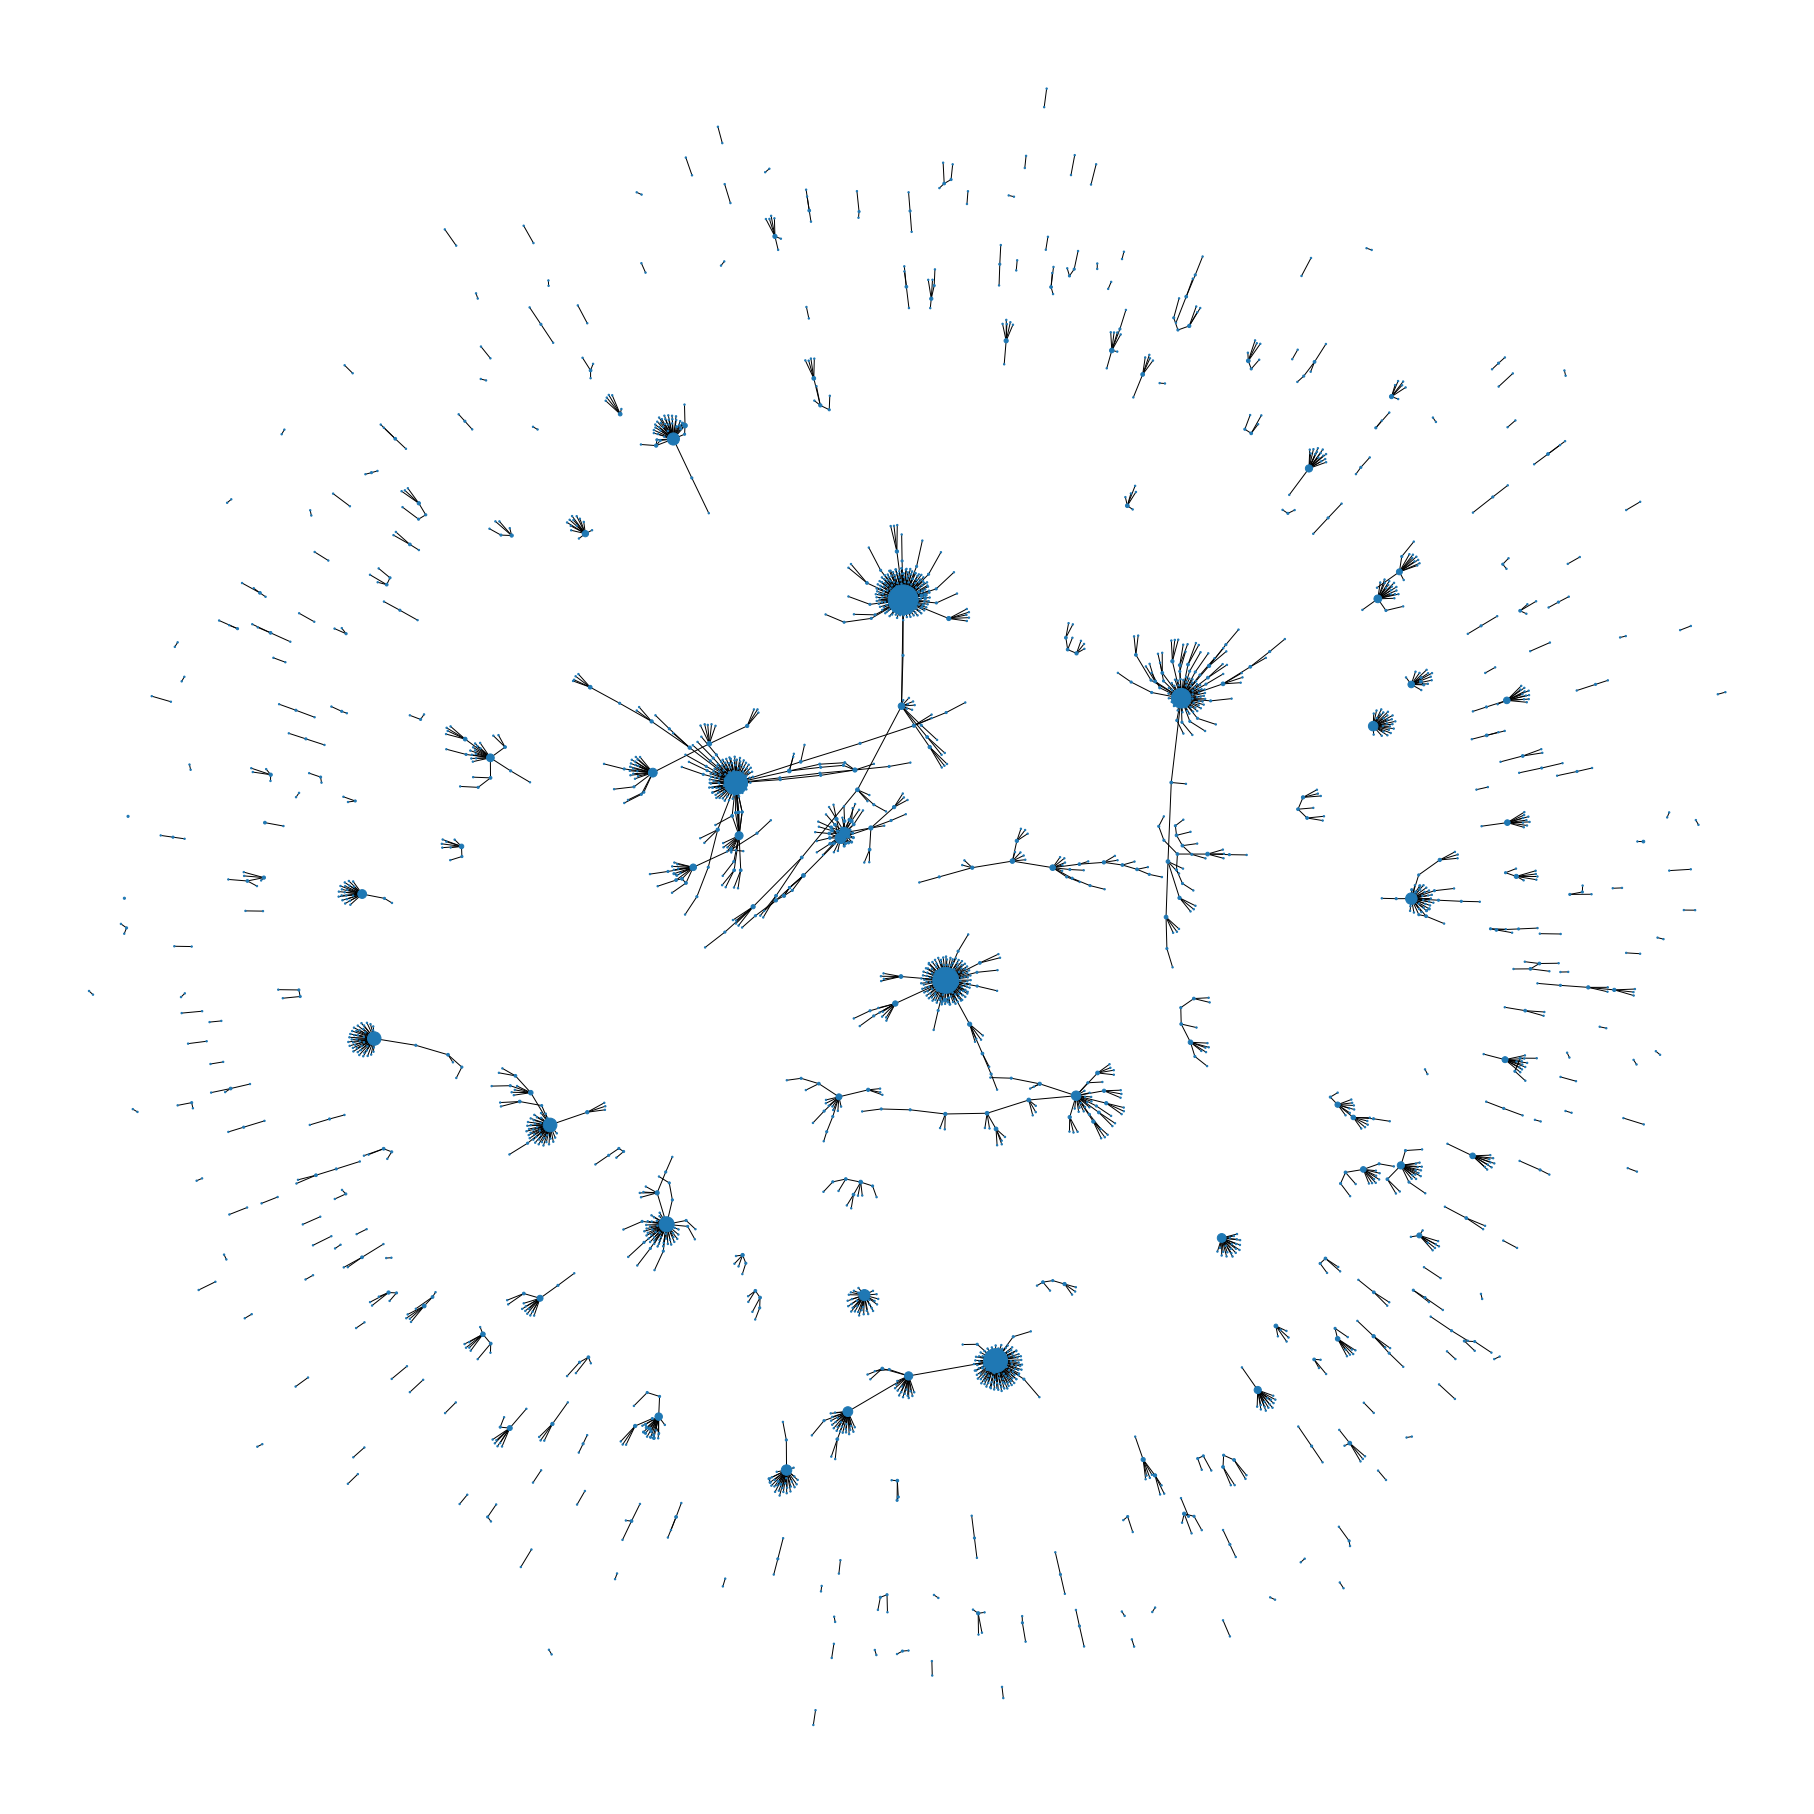

In [4]:
G = nx.Graph()

for _, row in patient.iterrows():
    if (not pd.isnull(row['infected_by'])):
        G.add_edge(row.patient_id,row.infected_by)
    if((not pd.isnull(row['infection_case'])) and (row['infection_case'] not in ["contact with patient","overseas inflow","etc"])):
        G.add_edge(row.patient_id,row.infection_case)

d = dict(G.degree)

nx.draw_spring(G, with_labels=False, nodelist=d.keys(), node_size=[v**1.2 * 2 for v in d.values()])

plt.show()

# this shows patient <-> infected by, and patient <-> infection_case

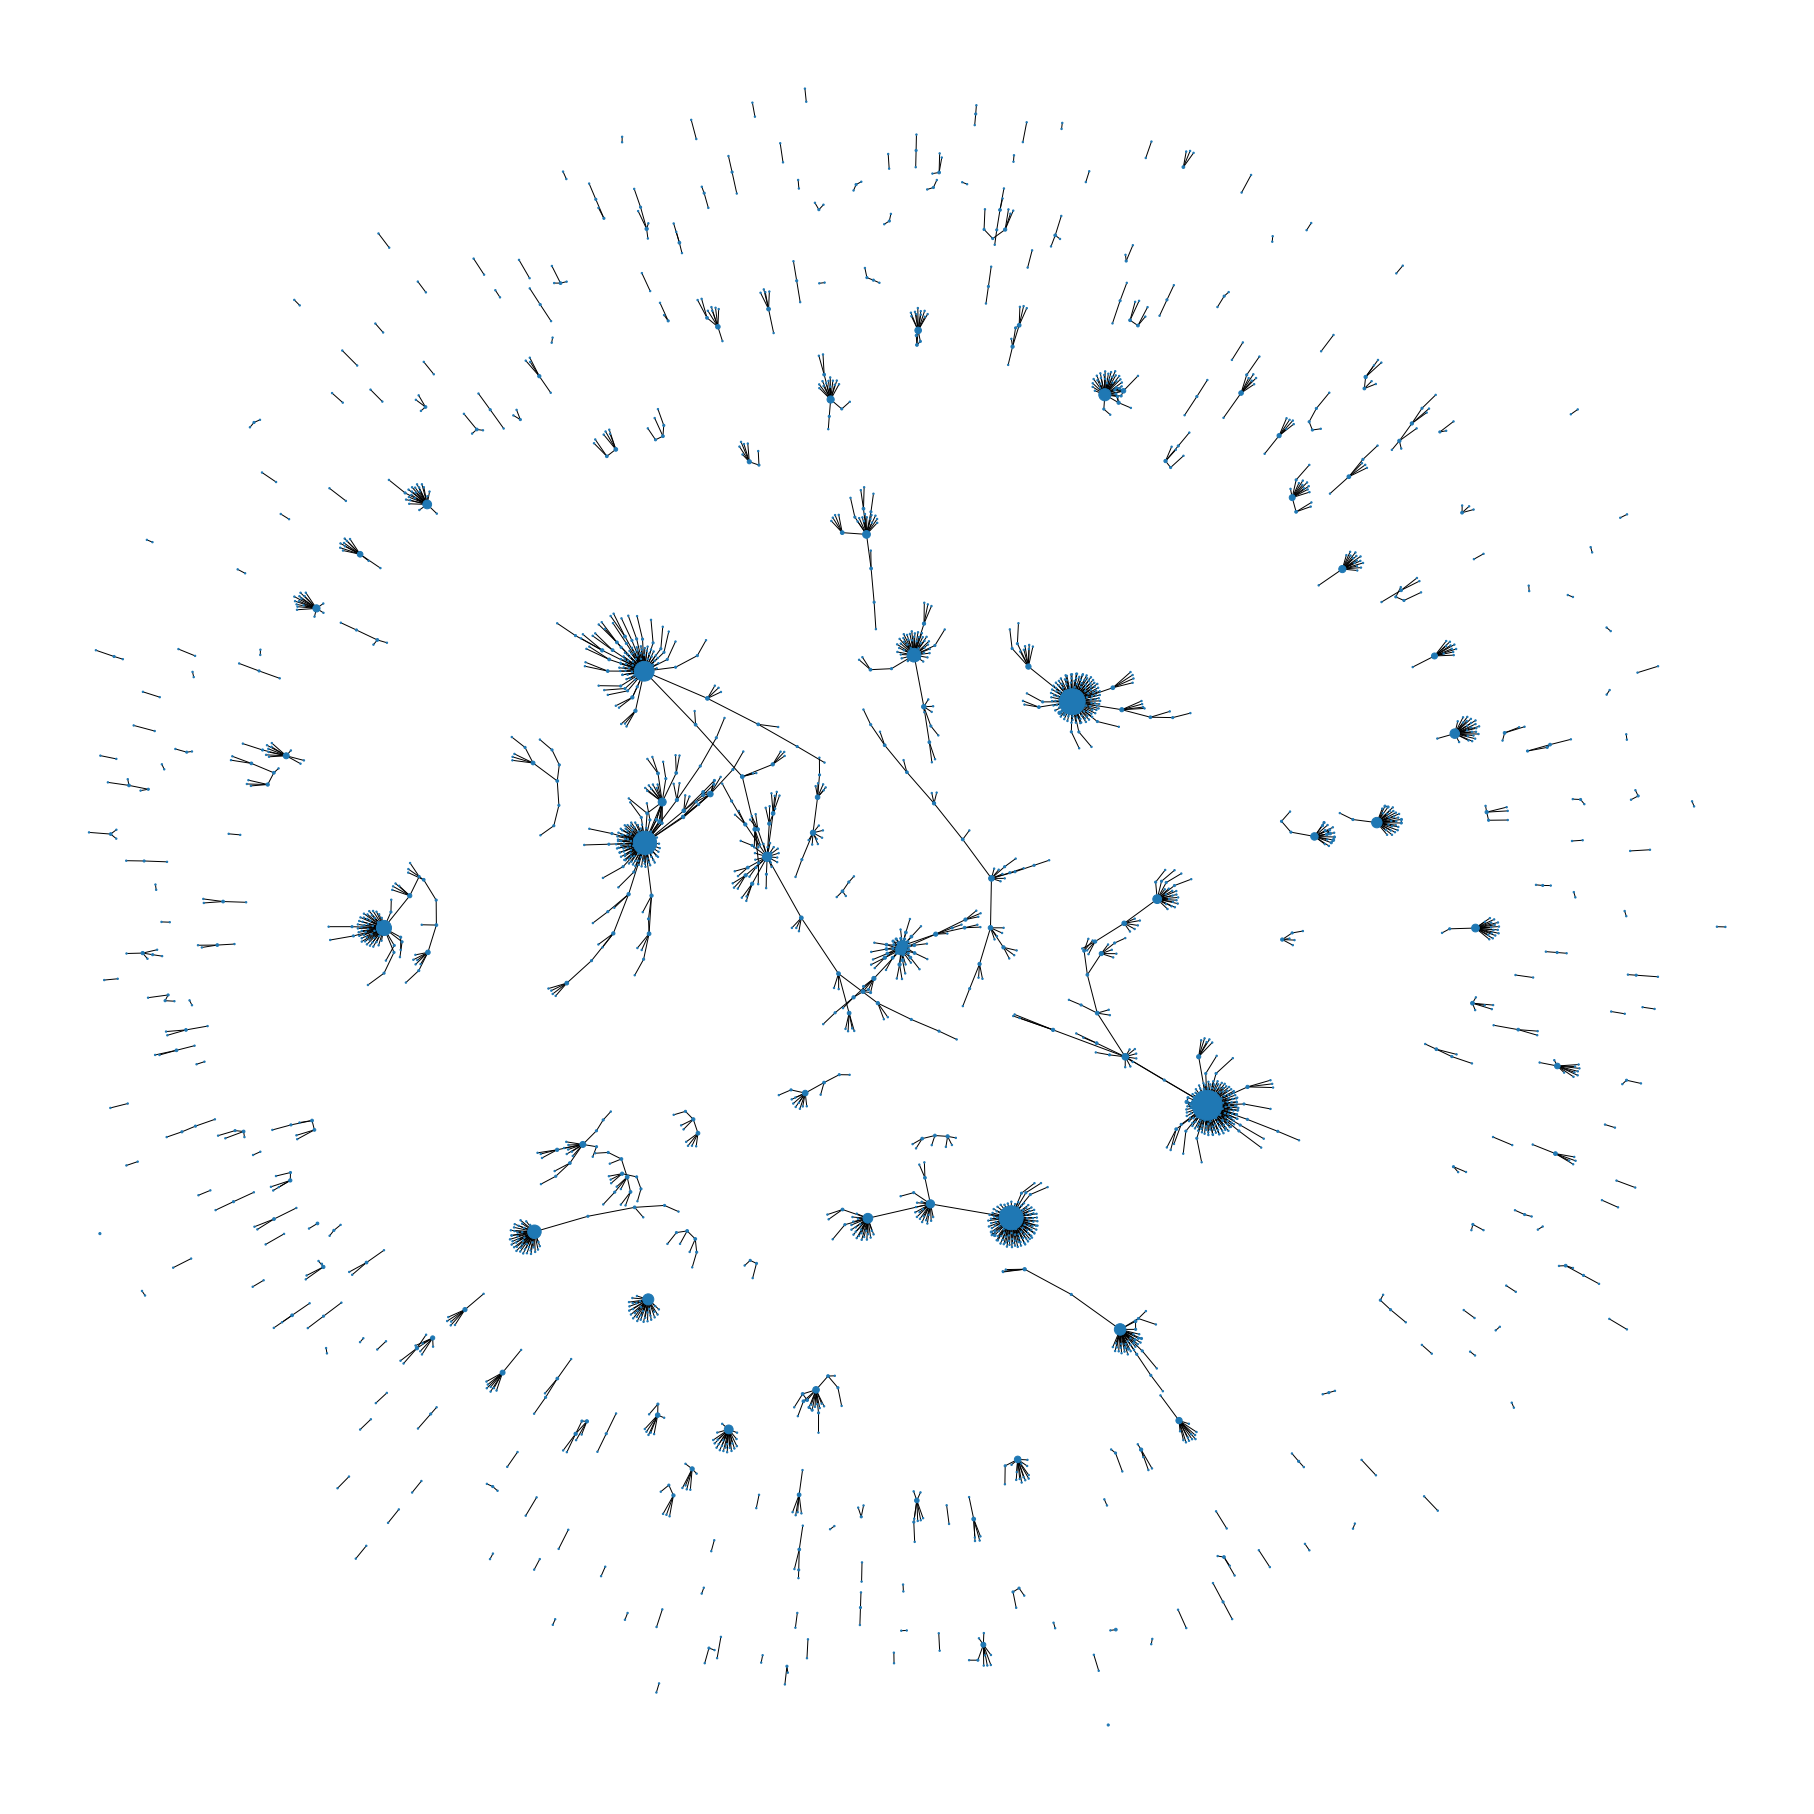

In [5]:
G = nx.Graph()

for _, row in patient.iterrows():
    if (not pd.isnull(row['infected_by'])):
        G.add_edge(row.patient_id,row.infected_by)
    if((not pd.isnull(row['infection_case'])) and (row['infection_case'] not in ["contact with patient","overseas inflow","etc"])):
        G.add_edge(row.patient_id,row.infection_case)
        if (not pd.isnull(row['infected_by'])):
            G.add_edge(row.infection_case,row.infected_by)

d = dict(G.degree)

nx.draw_spring(G, with_labels=False, nodelist=d.keys(), node_size=[v**1.2 * 2 for v in d.values()])
plt.show()

# this isn't a completely accurate representation - the problem is that for a lot of patient in the data, they
# don't have the "infection_case" as a group and an infected by at the same time (happens but rare).
# What I ended up doing was to plot all 3 relationship between patient, infection case, and infected by as
# edges in the network graph, resulting in probably a few more edges in the end.  However, this ended up linking
# some unconnected graphs.